In [ ]:
# from IPython.display import display,HTML
# display(HTML('<style>.container {width: 98% !important}</style>'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/dlnlp/assign4

/content/drive/MyDrive/dlnlp/assign4


In [ ]:
%matplotlib inline

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
days=['sunday ','monday ','tuesday ','wednesday ','thursday ','friday ','saturday ','sun ','mon ','tue ','wed ','thu ','fri ','sat ',"'"]
month={'january':'jan','february':'feb','march':'mar',
       'april':'apr','june':'jun','july':'jul','august':'aug','september':'sept','sep':'sept','october':'oct','november':'nov',
       'december':'dec'}


In [ ]:
cols=['Source','Target']
df=pd.read_csv('Assignment4aDataset.txt',names=cols, sep=', ',header=None)
print(df)

                       Source        Target
0               'may 20 2034'  '2034-05-20'
1                '9 may 1630'  '1630-05-09'
2                '15/03/2014'  '2014-03-15'
3               'mar 16 1675'  '1675-03-16'
4               'jun 16 1640'  '1640-06-16'
...                       ...           ...
39995      'december 26 1900'  '1900-12-26'
39996           '15 may 1828'  '1828-05-15'
39997  'friday april 18 1851'  '1851-04-18'
39998          'june 11 2070'  '2070-06-11'
39999       'january 27 1712'  '1712-01-27'

[40000 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
regx = r'({})'.format('|'.join(days))
df['Source'] = df['Source'].str.replace(regx, "").fillna(df['Source'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# replace space with slash
space=[' ']
regx2 = r'({})'.format('|'.join(space))
df['Source'] = df['Source'].str.replace(regx2, "/").fillna(df['Source'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [ ]:
d2 = {r'(\b){}(\b)'.format(k):r'\1{}\2'.format(v) for k,v in month.items()}
df['Source'] = df['Source'].replace(d2, regex=True)

In [ ]:
pre=["'"]
regx = r'({})'.format('|'.join(pre))
df['Target'] = df['Target'].str.replace(regx, "").fillna(df['Target'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(df)
df_train, df_valid = train_test_split(df, test_size=0.1)
print(len(df_train))
print(len(df_valid))

            Source      Target
0      may/20/2034  2034-05-20
1       9/may/1630  1630-05-09
2       15/03/2014  2014-03-15
3      mar/16/1675  1675-03-16
4      jun/16/1640  1640-06-16
...            ...         ...
39995  dec/26/1900  1900-12-26
39996  15/may/1828  1828-05-15
39997  apr/18/1851  1851-04-18
39998  jun/11/2070  2070-06-11
39999  jan/27/1712  1712-01-27

[40000 rows x 2 columns]
36000
4000


In [ ]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 11

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS":0,"EOS":1}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence,lang):
        if lang=='Source':
            words=[]
            nums=[]
            words=sentence.split('/')
            for w in words:
                if w.isdigit():
                    nums.extend(c for c in w)
                else:
                    nums.append(w)

                nums.append("/")
            nums=nums[:-1]
            for num in nums:
                self.addWord(num)
                
        else:
            words=[]
            nums=[]
            words=sentence.split('-')
            for w in words:
                if w.isdigit():
                    nums.extend(c for c in w)
                else:
                    nums.append(w)

                nums.append("-")
            nums=nums[:-1]
            for num in nums:
                self.addWord(num)
            
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def readLangs(lang1, lang2):
    print("Reading lines...")

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang

In [ ]:
def prepareData(lang1, lang2, df):
    input_lang, output_lang = readLangs(lang1, lang2)


    print("Counting words...")
    for i, row in enumerate(df.values):
        input_lang.addSentence(row[0],lang1)
        output_lang.addSentence(row[1],lang2)
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang


input_lang, output_lang = prepareData('Source', 'Target',df_train)
print(input_lang.word2index)
print(output_lang.word2index)


Reading lines...
Counting words...
Counted words:
Source 25
Target 13
{'SOS': 0, 'EOS': 1, '1': 2, '9': 3, '/': 4, 'nov': 5, '2': 6, '0': 7, '4': 8, 'jun': 9, '5': 10, '6': 11, '7': 12, 'may': 13, '8': 14, 'jul': 15, '3': 16, 'aug': 17, 'jan': 18, 'apr': 19, 'feb': 20, 'mar': 21, 'sept': 22, 'dec': 23, 'oct': 24}
{'SOS': 0, 'EOS': 1, '2': 2, '0': 3, '4': 4, '-': 5, '1': 6, '9': 7, '5': 8, '6': 9, '7': 10, '8': 11, '3': 12}


In [ ]:
print(output_lang.index2word)

{0: 'SOS', 1: 'EOS', 2: '2', 3: '0', 4: '4', 5: '-', 6: '1', 7: '9', 8: '5', 9: '6', 10: '7', 11: '8', 12: '3'}


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def indexesFromSentence(lang, sentence , name):
    if name=='Source':
        words=[]
        nums=[]
        words=sentence.split('/')
        for w in words:
            if w.isdigit():
                nums.extend(c for c in w)
            else:
                nums.append(w)

            nums.append("/")
        nums=nums[:-1]
        for num in nums:
            lang.addWord(num)

    else:
        words=[]
        nums=[]
        words=sentence.split('-')
        for w in words:
            if w.isdigit():
                nums.extend(c for c in w)
            else:
                nums.append(w)

            nums.append("-")
        nums=nums[:-1]
        for num in nums:
            lang.addWord(num)
            
    return [lang.word2index[word] for word in nums]


def tensorFromSentence(lang,sentence,name):
    indexes = indexesFromSentence(lang, sentence,name)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0],"Source")
    target_tensor = tensorFromSentence(output_lang, pair[1],"Target")
    return (input_tensor, target_tensor)



In [ ]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def validate(encoder, decoder, criterion,sentence,target, max_length=MAX_LENGTH):
    with torch.no_grad():
        
        input_tensor,target_tensor = tensorsFromPair([sentence,target])
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        pred=[]
        loss=0
        
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            
            loss += criterion(decoder_output, target_tensor[di])
            
            
            # pred.append(topi[0][0]== target_tensor[di][0])
            pred.append(topi[0][0].to('cpu')== target_tensor[di][0].to('cpu'))  ###### 
#             print(f'di:{di} topi={topi[0][0]} target_tensor[di] :{target_tensor[di][0]} ')
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                while di<MAX_LENGTH-1:
                    pred.append(False)
#                     print(f'di adding {di}')

                    di+=1
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        
#         print(len(pred))

        return decoder_attentions[:di + 1],np.array(pred),loss

In [ ]:
idx=0

In [ ]:
def getPair():
    global idx
    global df_train
#     print(idx)
    if idx==0:
        df_train = shuffle(df_train)
        
#     x=df_train.sample()
    retval=[df_train.iloc[idx]["Source"],df_train.iloc[idx]["Target"]]
    idx=(idx+1) % len(df_train)
    return retval



def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    plot_vlosses = []
    plot_vloss_total = 0
    min_vloss=np.inf
    model_no = 1

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
#     training_pairs = getPair()
    
#     training_pairs = [tensorsFromPair(getPair())
#                       for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = tensorsFromPair(getPair())
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            
#             validate_iter(encoder, decoder)
            tot_vloss=0
            exact_acc=0
            avg_acc=0
            

            
            pred_tot = np.zeros(MAX_LENGTH) 
            
            
            for i in range(len(df_valid)):
                dec_att, pred, vloss = validate(encoder, decoder,criterion,df_valid.iloc[i]['Source'], df_valid.iloc[i]['Target'], max_length=MAX_LENGTH)
                
#                 print(f'pred_tot: {pred_tot}')
#                 print(f'pred: {pred}')
                
                pred_tot += pred
                
                tot_vloss += vloss
                plot_vloss_total += loss
                sum_pred = np.sum(pred)    #shoud be pred?
                if sum_pred == MAX_LENGTH:
                    exact_acc+=1
                    
                avg_acc += sum_pred/MAX_LENGTH     
                    
                
                
            print(f'Valid_Loss: {tot_vloss/len(df_valid)}, Pred per bit: {pred_tot/len(df_valid)}')
            print(f'Exact Acc: {exact_acc/len(df_valid)}, Avg Acc: {avg_acc/len(df_valid)}')
                
            if min_vloss > tot_vloss:
                torch.save(encoder.state_dict(), 'encoder'+ str(model_no)+'.pth')
                torch.save(decoder.state_dict(), 'decoder'+ str(model_no)+'.pth')
                model_no += 1
                min_vloss = tot_vloss
                print("Model "+str(model_no)+" Saved")
                

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
            plot_vloss_avg = plot_vloss_total / plot_every
            plot_vlosses.append(plot_vloss_avg)
            plot_vloss_total = 0
            

    showPlot(plot_losses)
    showPlot(plot_vlosses)

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
#     plt.plot(vpoints)

In [ ]:
hidden_size = 50
epoch=10
n_iters=epoch*len(df_train)
print(n_iters)
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.4).to(device)

trainIters(encoder1, attn_decoder1, n_iters=n_iters, print_every=9000)

360000


  2%|▏         | 8997/360000 [03:07<2:05:47, 46.51it/s]

3m 7s (- 121m 43s) (9000 2%) 0.6235


  3%|▎         | 9005/360000 [03:43<162:56:49,  1.67s/it]

Valid_Loss: 4.081368923187256, Pred per bit: [0.98675 0.914   0.84525 0.80325 0.998   0.858   0.6375  0.99775 0.91125
 0.8825  0.9945 ]
Exact Acc: 0.51425, Avg Acc: 0.8935227272727363
Model 2 Saved


  5%|▍         | 17994/360000 [06:46<2:02:36, 46.49it/s]

6m 47s (- 128m 55s) (18000 5%) 0.1981


  5%|▌         | 18005/360000 [07:23<140:07:00,  1.47s/it]

Valid_Loss: 2.6333227157592773, Pred per bit: [0.98975 0.96025 0.924   0.88    0.99625 0.939   0.73525 0.99625 0.94375
 0.94825 0.9945 ]
Exact Acc: 0.634, Avg Acc: 0.937022727272739
Model 3 Saved


  7%|▋         | 26998/360000 [10:27<1:51:43, 49.67it/s]

10m 27s (- 128m 54s) (27000 7%) 0.1399


  8%|▊         | 27005/360000 [11:02<149:01:21,  1.61s/it]

Valid_Loss: 2.033823251724243, Pred per bit: [0.9865  0.962   0.956   0.9225  0.99875 0.964   0.7715  0.9985  0.9605
 0.94325 0.998  ]
Exact Acc: 0.687, Avg Acc: 0.951045454545467
Model 4 Saved


 10%|▉         | 35999/360000 [14:06<1:51:18, 48.51it/s]

14m 6s (- 126m 56s) (36000 10%) 0.1232


 10%|█         | 36005/360000 [14:42<156:26:49,  1.74s/it]

Valid_Loss: 1.5788260698318481, Pred per bit: [0.991   0.956   0.97075 0.9365  0.99925 0.96725 0.82175 0.99875 0.9645
 0.96825 0.998  ]
Exact Acc: 0.74875, Avg Acc: 0.9610909090909187
Model 5 Saved


 12%|█▏        | 44999/360000 [17:44<1:45:37, 49.70it/s]

17m 44s (- 124m 12s) (45000 12%) 0.0864


 13%|█▎        | 45005/360000 [18:20<144:15:34,  1.65s/it]

Valid_Loss: 1.2081525325775146, Pred per bit: [0.99075 0.96525 0.98    0.9535  1.      0.97175 0.89725 1.      0.97375
 0.9625  1.     ]
Exact Acc: 0.82, Avg Acc: 0.9722500000000077
Model 6 Saved


 15%|█▍        | 53998/360000 [21:22<1:42:04, 49.96it/s]

21m 22s (- 121m 7s) (54000 15%) 0.1005


 15%|█▌        | 54005/360000 [21:58<135:25:55,  1.59s/it]

Valid_Loss: 1.1445848941802979, Pred per bit: [0.989   0.96275 0.97425 0.95925 0.9995  0.985   0.9165  0.99925 0.97275
 0.9715  0.999  ]
Exact Acc: 0.848, Avg Acc: 0.9753409090909158
Model 7 Saved


 17%|█▋        | 62996/360000 [25:00<1:38:01, 50.50it/s]

25m 0s (- 117m 55s) (63000 17%) 0.0737


 18%|█▊        | 63005/360000 [25:37<121:11:50,  1.47s/it]

Valid_Loss: 1.008111834526062, Pred per bit: [0.98775 0.96575 0.98375 0.97    0.99975 0.98875 0.9505  0.99975 0.96775
 0.9635  0.99975]
Exact Acc: 0.88175, Avg Acc: 0.9797272727272772
Model 8 Saved


 20%|█▉        | 71998/360000 [28:39<1:34:34, 50.75it/s]

28m 39s (- 114m 37s) (72000 20%) 0.0514


 20%|██        | 72005/360000 [29:14<123:29:52,  1.54s/it]

Valid_Loss: 0.6472977995872498, Pred per bit: [0.9915  0.96875 0.98925 0.97725 0.99975 0.9935  0.97075 0.99975 0.98
 0.984   0.99975]
Exact Acc: 0.9155, Avg Acc: 0.9867500000000033
Model 9 Saved


 22%|██▏       | 80994/360000 [32:16<1:33:45, 49.60it/s]

32m 16s (- 111m 9s) (81000 22%) 0.0364


 23%|██▎       | 81006/360000 [32:51<100:40:29,  1.30s/it]

Valid_Loss: 0.5698298811912537, Pred per bit: [0.9885  0.97025 0.98825 0.9845  0.99975 0.99775 0.98425 0.99975 0.9805
 0.98375 0.9995 ]
Exact Acc: 0.92725, Avg Acc: 0.9887954545454575
Model 10 Saved


 25%|██▍       | 89996/360000 [35:52<1:29:14, 50.42it/s]

35m 52s (- 107m 38s) (90000 25%) 0.0294


 25%|██▌       | 90005/360000 [36:28<106:27:10,  1.42s/it]

Valid_Loss: 0.40650781989097595, Pred per bit: [0.99425 0.968   0.99425 0.9885  1.      0.998   0.99375 1.      0.987
 0.98925 1.     ]
Exact Acc: 0.94575, Avg Acc: 0.9920909090909118
Model 11 Saved


 27%|██▋       | 98997/360000 [39:29<1:25:31, 50.86it/s]

39m 29s (- 104m 6s) (99000 27%) 0.0279


 28%|██▊       | 99006/360000 [40:04<101:29:38,  1.40s/it]

Valid_Loss: 0.487383097410202, Pred per bit: [0.98625 0.9695  0.99175 0.98675 1.      0.996   0.98825 1.      0.9915
 0.991   1.     ]
Exact Acc: 0.939, Avg Acc: 0.9910000000000029


 30%|██▉       | 107999/360000 [43:07<1:24:22, 49.78it/s]

43m 7s (- 100m 36s) (108000 30%) 0.0264


 30%|███       | 108005/360000 [43:42<116:03:32,  1.66s/it]

Valid_Loss: 0.39895710349082947, Pred per bit: [0.99025 0.9705  0.994   0.9815  0.9995  0.9975  0.9895  0.9995  0.99325
 0.99325 0.9995 ]
Exact Acc: 0.94225, Avg Acc: 0.9916590909090931
Model 12 Saved


 32%|███▏      | 116997/360000 [46:52<1:22:08, 49.31it/s]

46m 52s (- 97m 20s) (117000 32%) 0.1310


 33%|███▎      | 117005/360000 [47:29<113:03:04,  1.67s/it]

Valid_Loss: 2.962000608444214, Pred per bit: [0.9805  0.89175 0.8925  0.8685  0.9975  0.937   0.851   0.9965  0.9325
 0.8965  0.994  ]
Exact Acc: 0.5945, Avg Acc: 0.9307500000000135


 35%|███▍      | 125997/360000 [50:35<1:21:49, 47.66it/s]

50m 35s (- 93m 57s) (126000 35%) 0.1006


 35%|███▌      | 126005/360000 [51:11<106:35:38,  1.64s/it]

Valid_Loss: 0.9934296011924744, Pred per bit: [0.991   0.9685  0.9765  0.95925 0.999   0.98775 0.95775 0.999   0.97
 0.96975 0.999  ]
Exact Acc: 0.875, Avg Acc: 0.9797727272727323


 37%|███▋      | 134998/360000 [54:16<1:14:38, 50.24it/s]

54m 17s (- 90m 28s) (135000 37%) 0.0509


 38%|███▊      | 135005/360000 [54:52<97:26:04,  1.56s/it] 

Valid_Loss: 0.6258083581924438, Pred per bit: [0.99325 0.96875 0.9775  0.9765  0.99975 0.996   0.99    0.99975 0.97275
 0.98125 0.99975]
Exact Acc: 0.9025, Avg Acc: 0.9868409090909145


 40%|███▉      | 143995/360000 [57:57<1:11:54, 50.06it/s]

57m 58s (- 86m 57s) (144000 40%) 0.0383


 40%|████      | 144005/360000 [58:33<85:31:19,  1.43s/it] 

Valid_Loss: 0.5318061113357544, Pred per bit: [0.9875  0.9695  0.99175 0.98475 1.      0.9955  0.9945  1.      0.976
 0.981   0.99975]
Exact Acc: 0.93, Avg Acc: 0.9891136363636396


 42%|████▏     | 152995/360000 [1:01:37<1:09:47, 49.44it/s]

61m 37s (- 83m 22s) (153000 42%) 0.0311


 43%|████▎     | 153005/360000 [1:02:13<82:05:34,  1.43s/it] 

Valid_Loss: 0.5157913565635681, Pred per bit: [0.99    0.9685  0.99125 0.98675 0.99975 0.99925 0.99475 0.99975 0.97825
 0.9815  0.99975]
Exact Acc: 0.9335, Avg Acc: 0.9899545454545488


 45%|████▍     | 161994/360000 [1:05:19<1:09:15, 47.65it/s]

65m 19s (- 79m 50s) (162000 45%) 0.0293


 45%|████▌     | 162005/360000 [1:05:55<79:46:21,  1.45s/it] 

Valid_Loss: 0.44455039501190186, Pred per bit: [0.99125 0.96725 0.99225 0.98875 1.      0.9985  0.99275 1.      0.98075
 0.985   1.     ]
Exact Acc: 0.9355, Avg Acc: 0.9905909090909121


 47%|████▋     | 170999/360000 [1:09:00<1:07:00, 47.01it/s]

69m 0s (- 76m 16s) (171000 47%) 0.0411


 48%|████▊     | 171005/360000 [1:09:36<92:36:27,  1.76s/it] 

Valid_Loss: 1.3090360164642334, Pred per bit: [0.991   0.9705  0.97    0.9745  0.999   0.99325 0.97475 0.999   0.96475
 0.8635  0.998  ]
Exact Acc: 0.8005, Avg Acc: 0.9725681818181916


 50%|████▉     | 179999/360000 [1:12:40<1:01:41, 48.63it/s]

72m 40s (- 72m 40s) (180000 50%) 0.0508


 50%|█████     | 180005/360000 [1:13:15<86:39:45,  1.73s/it] 

Valid_Loss: 0.5042775869369507, Pred per bit: [0.994   0.972   0.9905  0.98425 0.999   0.9965  0.9915  0.99875 0.9835
 0.987   0.9985 ]
Exact Acc: 0.938, Avg Acc: 0.9905000000000028


 52%|█████▏    | 188994/360000 [1:16:16<55:38, 51.23it/s]

76m 16s (- 69m 1s) (189000 52%) 0.0273


 53%|█████▎    | 189006/360000 [1:16:51<59:11:17,  1.25s/it]

Valid_Loss: 0.4536558985710144, Pred per bit: [0.993   0.9705  0.994   0.989   0.99975 0.99625 0.9915  0.99975 0.98075
 0.98575 0.99975]
Exact Acc: 0.936, Avg Acc: 0.9909090909090943


 55%|█████▍    | 197999/360000 [1:19:51<53:55, 50.07it/s]

79m 51s (- 65m 20s) (198000 55%) 0.0208


 55%|█████▌    | 198005/360000 [1:20:26<72:07:45,  1.60s/it] 

Valid_Loss: 0.2571902871131897, Pred per bit: [0.994   0.971   0.9935  0.99375 1.      0.99875 0.999   1.      0.99675
 0.996   1.     ]
Exact Acc: 0.95925, Avg Acc: 0.9947954545454566
Model 13 Saved


 57%|█████▋    | 206997/360000 [1:23:25<51:49, 49.20it/s]

83m 25s (- 61m 39s) (207000 57%) 0.0233


 58%|█████▊    | 207005/360000 [1:24:00<64:15:34,  1.51s/it]

Valid_Loss: 0.2969394624233246, Pred per bit: [0.99125 0.97225 0.99525 0.994   1.      0.99975 0.99825 1.      0.9935
 0.9915  1.     ]
Exact Acc: 0.957, Avg Acc: 0.994159090909093


 60%|█████▉    | 215996/360000 [1:27:00<47:24, 50.63it/s]

87m 0s (- 58m 0s) (216000 60%) 0.0454


 60%|██████    | 216005/360000 [1:27:33<53:25:15,  1.34s/it]

Valid_Loss: 41.95838928222656, Pred per bit: [0.81675 0.122   0.12875 0.14175 0.06175 0.20125 0.1255  0.0935  0.14225
 0.1045  0.002  ]
Exact Acc: 0.0, Avg Acc: 0.17636363636363042


 62%|██████▏   | 224994/360000 [1:30:31<44:24, 50.67it/s]

90m 31s (- 54m 19s) (225000 62%) 1.2014


 63%|██████▎   | 225005/360000 [1:31:06<50:14:06,  1.34s/it]

Valid_Loss: 16.449495315551758, Pred per bit: [0.985   0.85825 0.3655  0.274   0.87625 0.7555  0.36675 0.8755  0.733
 0.27675 0.87525]
Exact Acc: 0.005, Avg Acc: 0.6583409090909061


 65%|██████▍   | 233999/360000 [1:34:06<41:34, 50.52it/s]

94m 6s (- 50m 40s) (234000 65%) 0.5684


 65%|██████▌   | 234005/360000 [1:34:42<56:17:10,  1.61s/it]

Valid_Loss: 5.566603660583496, Pred per bit: [0.983   0.9085  0.691   0.58625 0.998   0.88725 0.65425 0.99775 0.88125
 0.62525 0.99775]
Exact Acc: 0.18225, Avg Acc: 0.8372954545454689


 67%|██████▋   | 242999/360000 [1:37:41<38:39, 50.45it/s]

97m 41s (- 47m 2s) (243000 67%) 0.3517


 68%|██████▊   | 243005/360000 [1:38:16<52:01:48,  1.60s/it]

Valid_Loss: 4.136204719543457, Pred per bit: [0.981   0.91675 0.787   0.7065  0.996   0.92975 0.76225 0.99575 0.91175
 0.791   0.99575]
Exact Acc: 0.3505, Avg Acc: 0.8885000000000215


 70%|██████▉   | 251996/360000 [1:41:15<35:39, 50.48it/s]

101m 15s (- 43m 23s) (252000 70%) 0.2478


 70%|███████   | 252005/360000 [1:41:51<42:36:51,  1.42s/it]

Valid_Loss: 3.142787218093872, Pred per bit: [0.98275 0.9425  0.88775 0.83975 0.99425 0.9595  0.8635  0.99425 0.90775
 0.855   0.99375]
Exact Acc: 0.56975, Avg Acc: 0.9291590909091066


 72%|███████▏  | 260995/360000 [1:44:51<32:00, 51.56it/s]

104m 51s (- 39m 46s) (261000 72%) 0.1845


 73%|███████▎  | 261005/360000 [1:45:26<37:34:01,  1.37s/it]

Valid_Loss: 2.3774585723876953, Pred per bit: [0.989   0.9535  0.926   0.86225 0.9985  0.977   0.872   0.9985  0.906
 0.85175 0.9985 ]
Exact Acc: 0.57375, Avg Acc: 0.9393636363636554


 75%|███████▍  | 269996/360000 [1:48:26<30:18, 49.50it/s]

108m 26s (- 36m 8s) (270000 75%) 0.1444


 75%|███████▌  | 270005/360000 [1:49:01<37:26:42,  1.50s/it]

Valid_Loss: 2.985293388366699, Pred per bit: [0.98675 0.94825 0.916   0.87225 0.98975 0.95    0.9035  0.9895  0.93725
 0.90625 0.98925]
Exact Acc: 0.672, Avg Acc: 0.9444318181818311


 77%|███████▋  | 278997/360000 [1:52:03<26:46, 50.44it/s]

112m 3s (- 32m 31s) (279000 77%) 0.1273


 78%|███████▊  | 279005/360000 [1:52:38<33:13:42,  1.48s/it]

Valid_Loss: 1.7741495370864868, Pred per bit: [0.9895  0.95725 0.95625 0.93475 0.997   0.97925 0.937   0.99525 0.9535
 0.94075 0.99525]
Exact Acc: 0.78375, Avg Acc: 0.9668863636363738


 80%|███████▉  | 287994/360000 [1:55:38<24:44, 48.51it/s]

115m 39s (- 28m 54s) (288000 80%) 0.1065


 80%|████████  | 288005/360000 [1:56:14<28:04:12,  1.40s/it]

Valid_Loss: 1.247326374053955, Pred per bit: [0.99125 0.9635  0.96225 0.95275 0.99775 0.98275 0.96625 0.99775 0.978
 0.9565  0.99775]
Exact Acc: 0.844, Avg Acc: 0.9769545454545531


 82%|████████▏ | 296999/360000 [1:59:15<20:49, 50.40it/s]

119m 15s (- 25m 17s) (297000 82%) 0.0753


 83%|████████▎ | 297005/360000 [1:59:50<28:31:03,  1.63s/it]

Valid_Loss: 1.1708712577819824, Pred per bit: [0.992   0.964   0.97025 0.9665  0.9985  0.987   0.93075 0.99825 0.97475
 0.961   0.99825]
Exact Acc: 0.82775, Avg Acc: 0.9764772727272811


 84%|████████▍ | 302482/360000 [2:01:40<18:55, 50.65it/s]

In [ ]:
pip install faker

In [ ]:
pip install babel

In [ ]:
from faker import Faker
import random
from babel.dates import format_date
from tqdm import tqdm

In [ ]:
fake = Faker()



# We need to seed these guys. For some reason I always use 101
Faker.seed(101)
random.seed(101)



FORMATS = ['short', # d/M/YY
           'medium', # MMM d, YYY
           'medium',
           'medium',
           'long', # MMMM dd, YYY
           'long',
           'long',
           'long',
           'long',
           'full', # EEEE, MMM dd, YYY
           'full',
           'full',
           'd MMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'dd/MM/YYY',
           'EE d, MMM YYY',
           'EEEE d, MMMM YYY']

In [ ]:
for format in FORMATS:
    print('%s => %s' %(format, format_date(fake.date_object(), format=format, locale='en')))

In [ ]:
def random_date():
    dt = fake.date_object()



    try:
        date = format_date(dt, format=random.choice(FORMATS), locale='en')
        human_readable = date.lower().replace(',', '')
        machine_readable = dt.isoformat()



    except AttributeError as e:
        return None, None, None



    return human_readable, machine_readable, dt




def create_dataset(m):
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    
    for i in tqdm(range(m)):
        h, m, _ = random_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    # We also add two special chars, <unk> for unknown characters, and <pad> to add padding at the end
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v: k for k, v in inv_machine.items()}

    return dataset, human, machine, inv_machine

In [ ]:
m = 4000
test_dataset, human_vocab, machine_vocab, inv_machine_vocab = create_dataset(m)
print(test_dataset[:10])

In [ ]:
cols=['Source','Target']
df_test=pd.read_csv('Assignment4aTestDataset.txt',names=cols, sep=', ',header=None)

# df_test=pd.DataFrame(test_dataset,columns=["Source","Target"])
print(df_test)

In [ ]:
def preproc(df):
    days=['sunday ','monday ','tuesday ','wednesday ','thursday ','friday ','saturday ','sun ','mon ','tue ','wed ','thu ','fri ','sat ',"'"]
    month={'january':'jan','february':'feb','march':'mar',
       'april':'apr','june':'jun','july':'jul','august':'aug','september':'sept','sep':'sept','october':'oct','november':'nov',
       'december':'dec'}



    regx = r'({})'.format('|'.join(days))
    df['Source'] = df['Source'].str.replace(regx, "").fillna(df['Source'])



   # replace space with slash
    space=[' ']
    regx2 = r'({})'.format('|'.join(space))
    df['Source'] = df['Source'].str.replace(regx2, "/").fillna(df['Source'])



    d2 = {r'(\b){}(\b)'.format(k):r'\1{}\2'.format(v) for k,v in month.items()}
    df['Source'] = df['Source'].replace(d2, regex=True)



    pre=["'"]
    regx = r'({})'.format('|'.join(pre))
    df['Target'] = df['Target'].str.replace(regx, "").fillna(df['Target'])
    return df

In [ ]:
df_test=preproc(df_test)
print(df_test)

In [ ]:

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence,"Source")
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1],input_tensor

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
def showAttention(input_sentence, output_words, attentions,input_tensor):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes

    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    
    ip=[]
    for i in input_tensor.cpu().detach().numpy():
        ip.append(input_lang.index2word[i[0]])
    print(ip)
    ax.set_xticklabels(['']+ip)
    
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions,input_tensor = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print(torch.sum(attentions, axis=0))
    print(torch.sum(attentions, axis=1))
    print('attention shape =', attentions.shape)
    print('output =', ' '.join(output_words))
    plt.matshow(attentions)
    showAttention(input_sentence, output_words, attentions,input_tensor)

In [ ]:
hidden_size = 50
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.4).to(device)

PATHe='encoder6.pth'
PATHd='decoder6.pth'
encoder1.load_state_dict(torch.load(PATHe))
attn_decoder1.load_state_dict(torch.load(PATHd))

In [ ]:
def test_df(df_valid,encoder, decoder, criterion=nn.NLLLoss(), max_length=MAX_LENGTH):
    tot_vloss=0
    exact_acc=0
    avg_acc=0
    pred_tot=np.zeros(MAX_LENGTH)



    for i in range(len(df_valid)):
        
        dec_att,pred,vloss = validate(encoder, decoder,criterion,
                                    df_valid.iloc[i]['Source'],
                 df_valid.iloc[i]['Target'], max_length=MAX_LENGTH)

        pred_tot+=pred

        tot_vloss+=vloss
        sum_pred=np.sum(pred)   
        if sum_pred == MAX_LENGTH:
            exact_acc+=1

        avg_acc+=sum_pred/MAX_LENGTH
    
    return avg_acc,exact_acc,tot_vloss, pred_tot

In [ ]:
avg_acc,exact_acc,tot_vloss, pred_tot=test_df(df_test,encoder1, attn_decoder1)
print(avg_acc/len(df_test))
print(exact_acc/len(df_test))
print(tot_vloss/len(df_test))
print(pred_tot/len(df_test))

In [ ]:
avg_acc,exact_acc,tot_vloss, pred_tot=test_df(df_valid,encoder1, attn_decoder1)
print(avg_acc/len(df_test))
print(exact_acc/len(df_test))
print(tot_vloss/len(df_test))
print(pred_tot/len(df_test))

In [ ]:
hidden_size = 50
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.4).to(device)

PATHe='v2/encoder.pth'
PATHd='v2/decoder.pth'
encoder1.load_state_dict(torch.load(PATHe))
attn_decoder1.load_state_dict(torch.load(PATHd))

In [ ]:
avg_acc,exact_acc,tot_vloss, pred_tot=test_df(df_test,encoder1, attn_decoder1)
print(avg_acc/len(df_test))
print(exact_acc/len(df_test))
print(tot_vloss/len(df_test))
print(pred_tot/len(df_test))

In [ ]:
evaluateAndShowAttention(df_valid.iloc[35]["Source"])

In [ ]:
evaluateAndShowAttention(df_valid.iloc[45]["Source"])

input = 18/01/1976
tensor([[2.7548e-10, 2.3940e-12, 7.8276e-10, 9.2149e-10, 4.7364e-10, 1.0000e+00,
         5.8889e-11, 3.7651e-10, 1.5743e-11, 4.4716e-09, 3.3119e-09],
        [2.5357e-07, 9.9871e-01, 1.9411e-11, 1.2896e-03, 1.2729e-07, 7.2233e-11,
         3.7420e-11, 8.9900e-07, 1.0971e-07, 1.1530e-07, 2.9544e-07],
        [2.1140e-08, 8.0995e-11, 2.3561e-09, 1.0141e-06, 6.4554e-08, 7.5287e-13,
         6.4782e-11, 1.0000e+00, 5.6566e-07, 3.6009e-08, 3.0907e-08],
        [3.9874e-10, 1.3046e-14, 1.2195e-13, 3.3434e-12, 7.2665e-11, 2.2710e-17,
         5.3394e-13, 5.9919e-09, 1.0000e+00, 8.8257e-11, 6.7279e-11],
        [8.0871e-06, 4.8388e-19, 9.1536e-06, 1.3937e-12, 2.1285e-10, 6.5907e-15,
         6.8122e-16, 2.5691e-09, 9.9998e-01, 2.2775e-10, 1.5865e-10],
        [9.9991e-01, 2.4861e-16, 1.4062e-07, 1.4091e-14, 8.9018e-11, 5.0514e-10,
         1.9600e-19, 9.0231e-11, 9.2035e-05, 1.7031e-10, 8.7530e-11],
        [9.9987e-01, 6.7502e-09, 6.7270e-10, 1.2959e-04, 3.7623e-08, 1.3972

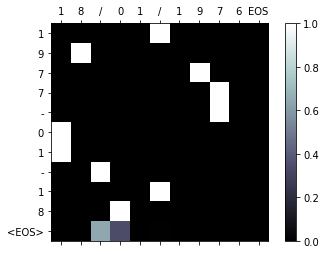


input = apr/18/2000
tensor([[3.3387e-15, 3.3234e-17, 1.3285e-14, 1.1648e-15, 7.4561e-14, 1.0000e+00,
         2.9655e-14, 3.2981e-11, 1.0247e-15, 3.3193e-13, 2.5406e-13],
        [1.1883e-07, 9.9527e-01, 1.9224e-09, 4.7144e-03, 1.1758e-06, 8.4821e-08,
         1.7610e-08, 8.0187e-06, 1.9571e-07, 1.9532e-06, 3.1276e-06],
        [1.8495e-04, 8.4596e-08, 3.0823e-08, 5.3785e-06, 1.8239e-05, 3.2012e-07,
         1.2176e-07, 9.9933e-01, 4.2326e-04, 1.7932e-05, 2.1775e-05],
        [1.3632e-06, 2.8999e-17, 7.9550e-11, 1.6327e-11, 1.5452e-08, 6.2369e-09,
         1.0396e-10, 1.3856e-05, 9.9998e-01, 8.8508e-09, 6.9337e-09],
        [1.0182e-02, 4.2497e-17, 2.4051e-06, 5.1545e-13, 1.1520e-08, 1.9236e-09,
         1.0251e-12, 7.4663e-08, 9.8982e-01, 1.1020e-08, 6.7631e-09],
        [1.0000e+00, 3.6960e-19, 4.4342e-09, 1.2704e-17, 4.9160e-12, 3.4127e-08,
         1.8179e-19, 4.7894e-12, 1.2557e-09, 3.2085e-12, 2.7091e-12],
        [9.9999e-01, 9.1191e-11, 4.2036e-09, 1.0970e-05, 4.3571e-08, 1.26

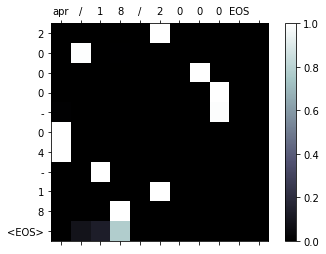


input = 23/may/2022
tensor([[2.4441e-14, 6.5565e-11, 5.6378e-13, 4.8770e-09, 2.8318e-11, 1.0000e+00,
         6.9792e-14, 7.8638e-10, 2.1973e-12, 1.9686e-10, 1.8380e-10],
        [5.0484e-10, 9.9924e-01, 1.5938e-13, 7.6235e-04, 1.9490e-08, 8.6983e-09,
         8.3578e-10, 2.8234e-07, 1.4123e-09, 3.9838e-08, 6.3431e-08],
        [2.7980e-08, 5.3718e-07, 8.2012e-12, 1.5259e-05, 7.9910e-07, 1.0276e-08,
         2.9252e-08, 9.9998e-01, 1.9303e-07, 5.9782e-07, 7.7555e-07],
        [2.3010e-11, 2.9052e-18, 1.5288e-16, 1.6772e-12, 3.0079e-12, 1.7900e-17,
         7.9962e-11, 8.8490e-11, 1.0000e+00, 3.2612e-12, 2.8978e-12],
        [5.4915e-06, 3.0689e-14, 5.9226e-09, 1.1663e-11, 1.4231e-10, 1.9660e-16,
         4.1325e-12, 1.7302e-12, 9.9999e-01, 2.8626e-10, 1.1787e-10],
        [9.9999e-01, 2.1969e-14, 1.2023e-08, 1.4089e-13, 3.1767e-10, 1.8685e-08,
         1.2951e-16, 5.0787e-11, 7.2834e-06, 6.5398e-10, 3.3666e-10],
        [9.9999e-01, 6.6270e-09, 1.5373e-10, 8.4399e-06, 2.9981e-08, 2.50

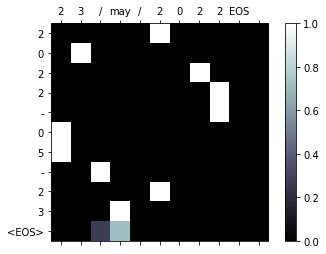


input = jul/26/2006
tensor([[2.2163e-15, 4.5876e-21, 1.2727e-16, 4.6061e-16, 2.0976e-15, 1.0000e+00,
         7.1803e-18, 2.8769e-13, 1.0334e-16, 1.5364e-14, 1.8379e-14],
        [3.0658e-08, 9.8634e-01, 4.2135e-10, 1.3501e-02, 1.9490e-06, 8.5011e-08,
         8.6932e-08, 1.4801e-04, 4.8947e-07, 3.8366e-06, 6.0482e-06],
        [3.5500e-05, 9.6576e-09, 4.2737e-10, 9.6245e-07, 3.5665e-06, 3.5483e-08,
         3.1390e-08, 9.9974e-01, 2.1131e-04, 3.9282e-06, 4.3517e-06],
        [1.9388e-06, 1.1312e-17, 9.6361e-12, 6.7804e-12, 7.7366e-09, 3.1333e-09,
         9.7799e-11, 1.1401e-05, 9.9999e-01, 4.9042e-09, 4.0571e-09],
        [2.2866e-06, 1.8308e-19, 2.6871e-07, 3.6939e-13, 7.4399e-11, 3.7546e-14,
         1.7190e-15, 1.3270e-06, 1.0000e+00, 2.0890e-10, 1.6368e-10],
        [1.0000e+00, 9.7418e-21, 6.2187e-09, 1.5283e-15, 3.1923e-12, 2.0694e-09,
         1.3791e-19, 2.9938e-11, 2.7297e-09, 3.4348e-12, 2.2744e-12],
        [9.9999e-01, 3.3549e-11, 1.1373e-09, 7.1594e-06, 1.3845e-08, 1.41

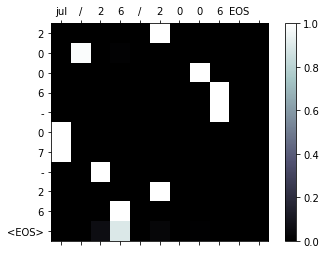


input = 10/dec/1994
tensor([[1.4102e-13, 1.3284e-16, 3.0896e-15, 1.7882e-14, 5.9035e-12, 1.0000e+00,
         9.2262e-10, 5.2632e-11, 1.4477e-11, 1.0450e-11, 1.6080e-11],
        [6.5306e-07, 9.9948e-01, 9.6908e-11, 5.1294e-04, 2.4961e-07, 2.2925e-10,
         8.5550e-11, 1.1950e-06, 6.9554e-07, 3.2185e-07, 5.8291e-07],
        [1.2153e-09, 2.3280e-13, 1.1914e-07, 1.2282e-07, 1.2393e-07, 3.2928e-11,
         1.4572e-07, 9.9996e-01, 4.0666e-05, 1.5920e-07, 7.7154e-08],
        [1.2095e-06, 8.7780e-15, 1.7303e-11, 4.2481e-12, 7.4733e-10, 1.2698e-15,
         9.9103e-15, 3.8115e-07, 1.0000e+00, 4.7082e-10, 4.3804e-10],
        [9.4794e-06, 3.5524e-17, 3.8653e-05, 3.7379e-14, 6.9738e-11, 3.8624e-17,
         2.2127e-17, 1.3153e-09, 9.9995e-01, 7.5823e-11, 6.0292e-11],
        [1.0000e+00, 2.0575e-17, 6.4956e-09, 8.0107e-17, 5.0066e-12, 2.0816e-10,
         5.2397e-20, 1.1350e-12, 5.9900e-09, 3.7419e-12, 2.8067e-12],
        [9.9998e-01, 8.1304e-09, 1.6949e-10, 1.7548e-05, 1.1606e-08, 1.90

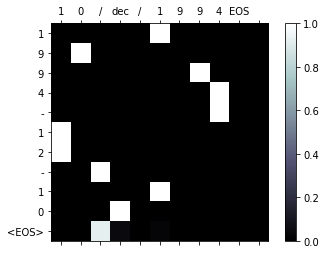


input = jan/15/1983
tensor([[2.2774e-13, 1.6038e-13, 1.7733e-15, 7.9131e-12, 6.7232e-12, 1.0000e+00,
         1.7990e-11, 5.5479e-12, 2.4333e-13, 2.2300e-11, 5.3238e-11],
        [6.6699e-08, 9.9990e-01, 1.0130e-12, 9.7240e-05, 2.9606e-08, 1.6504e-09,
         1.1105e-12, 1.7528e-07, 7.2677e-09, 2.4527e-08, 4.3112e-08],
        [1.0381e-09, 8.2283e-14, 1.6163e-09, 8.2066e-09, 2.9896e-08, 3.0810e-10,
         4.8599e-09, 1.0000e+00, 2.9712e-06, 3.0254e-08, 2.8042e-08],
        [1.9634e-08, 1.3384e-13, 9.0383e-13, 3.9493e-13, 1.2031e-09, 7.9322e-14,
         3.8605e-09, 4.4318e-08, 1.0000e+00, 9.7050e-10, 1.1382e-09],
        [4.7063e-04, 2.4484e-11, 2.8444e-06, 1.5005e-08, 6.1404e-08, 3.1250e-16,
         2.8994e-11, 1.3672e-10, 9.9953e-01, 1.6910e-08, 1.4903e-08],
        [1.0000e+00, 5.6111e-18, 1.5412e-09, 2.8172e-17, 2.2505e-12, 9.0354e-10,
         8.2920e-19, 3.1380e-13, 4.1163e-09, 2.4765e-12, 2.5823e-12],
        [9.9999e-01, 5.9203e-11, 7.1772e-10, 1.2869e-05, 1.4460e-08, 2.75

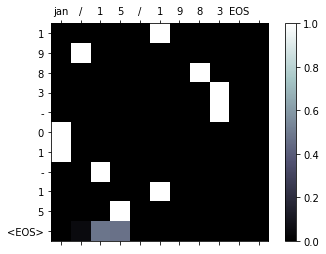


input = 5/feb/2002
tensor([[1.4711e-13, 2.0148e-13, 4.7232e-13, 2.0598e-10, 6.6538e-12, 1.0000e+00,
         2.0130e-16, 8.9594e-09, 4.6933e-13, 5.1239e-11, 6.5728e-11],
        [2.0049e-09, 9.9196e-01, 2.0779e-11, 8.0272e-03, 2.7206e-07, 3.5332e-09,
         1.5649e-08, 1.2275e-05, 3.9276e-08, 3.4061e-07, 5.6680e-07],
        [4.3583e-06, 8.5233e-10, 4.0170e-10, 1.8479e-07, 8.3774e-07, 3.7803e-09,
         8.3670e-09, 9.9990e-01, 9.7640e-05, 9.1751e-07, 9.0238e-07],
        [2.0799e-06, 2.0542e-13, 5.9482e-10, 7.2839e-11, 4.0133e-08, 1.4740e-09,
         1.3791e-11, 5.4717e-05, 9.9994e-01, 3.4133e-08, 3.3252e-08],
        [7.9000e-06, 2.0561e-14, 2.6226e-08, 5.7748e-11, 9.4780e-10, 8.6620e-15,
         4.9176e-15, 2.7009e-10, 9.9999e-01, 6.2703e-10, 5.3793e-10],
        [1.0000e+00, 3.7541e-16, 1.1059e-09, 1.0826e-15, 1.0068e-11, 1.3382e-10,
         2.0881e-19, 1.3934e-11, 4.8188e-08, 1.4062e-11, 9.0895e-12],
        [9.9999e-01, 5.7814e-10, 5.0302e-10, 7.8026e-06, 1.4644e-08, 1.438

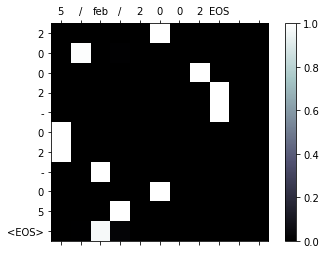


input = mar/9/1992
tensor([[3.8862e-16, 1.3285e-15, 4.6290e-17, 1.0419e-13, 5.1549e-14, 1.0000e+00,
         3.1308e-15, 3.9232e-12, 1.9727e-16, 1.8998e-13, 3.6270e-13],
        [2.1341e-08, 9.9976e-01, 6.2295e-14, 2.3603e-04, 1.3498e-08, 2.2738e-10,
         1.5312e-11, 1.5267e-07, 3.0638e-09, 1.5624e-08, 3.2783e-08],
        [4.7987e-12, 7.7266e-14, 2.7500e-10, 2.4458e-07, 2.5576e-08, 9.9614e-09,
         3.2511e-07, 1.0000e+00, 1.3859e-07, 3.3628e-08, 2.0877e-08],
        [8.0292e-11, 2.0232e-18, 9.8466e-14, 1.0842e-12, 1.0467e-10, 2.8672e-13,
         5.7766e-11, 3.8665e-07, 1.0000e+00, 8.2558e-11, 1.3751e-10],
        [1.6423e-04, 5.9545e-15, 4.7138e-08, 2.7431e-10, 1.4411e-09, 4.7151e-14,
         1.9277e-14, 9.7801e-11, 9.9984e-01, 1.4324e-09, 1.7666e-09],
        [1.0000e+00, 8.1051e-18, 2.7955e-11, 4.2756e-17, 1.1216e-12, 8.5789e-10,
         1.0360e-19, 6.5440e-13, 2.3628e-08, 1.6673e-12, 1.8200e-12],
        [9.9996e-01, 2.5926e-10, 1.2907e-09, 4.2102e-05, 3.3047e-08, 6.662

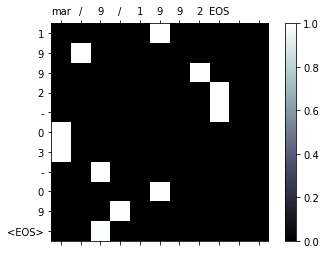


input = 2/apr/1986
tensor([[1.4579e-09, 9.9946e-10, 1.3872e-12, 3.1700e-08, 2.8971e-09, 1.0000e+00,
         4.4680e-13, 3.1521e-08, 2.5171e-08, 1.9999e-08, 1.7249e-08],
        [2.8010e-08, 9.9989e-01, 2.2113e-13, 1.0643e-04, 1.7000e-08, 8.9803e-11,
         1.3935e-12, 3.7801e-07, 1.3332e-08, 2.4004e-08, 3.6532e-08],
        [6.2862e-10, 2.4630e-13, 2.4840e-10, 1.4762e-09, 1.0529e-08, 1.4490e-11,
         1.9309e-09, 1.0000e+00, 3.3291e-06, 1.8210e-08, 1.1375e-08],
        [9.6058e-08, 2.2974e-14, 4.5880e-12, 3.0586e-11, 7.7931e-10, 8.9311e-15,
         8.0786e-14, 4.0041e-06, 1.0000e+00, 8.6624e-10, 7.5381e-10],
        [7.9660e-05, 4.4141e-19, 2.8485e-05, 3.3479e-13, 2.4711e-10, 4.0635e-15,
         2.9999e-15, 9.9361e-07, 9.9989e-01, 3.6867e-10, 3.4755e-10],
        [1.0000e+00, 3.9748e-18, 2.0083e-08, 3.1080e-17, 4.9716e-12, 5.0152e-09,
         1.9771e-19, 1.2383e-11, 1.9244e-08, 5.6063e-12, 5.9519e-12],
        [1.0000e+00, 4.4660e-11, 1.5093e-09, 4.4986e-06, 1.5137e-08, 9.796

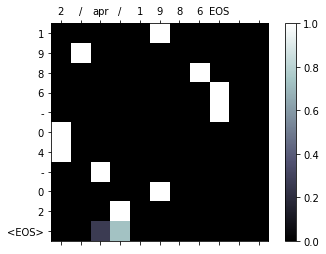

KeyboardInterrupt: ignored

In [ ]:
for i in range(len(df_test)):
  evaluateAndShowAttention(df_test.iloc[i]["Source"])
  x = input()

input = 18/01/1976
tensor([[2.2082e-13, 3.1477e-13, 1.1124e-13, 6.2484e-13, 5.2149e-13, 1.0000e+00,
         9.6304e-15, 7.8530e-14, 3.3162e-16, 4.7090e-12, 5.4810e-12],
        [2.2374e-07, 9.9855e-01, 1.3722e-11, 1.4489e-03, 1.3942e-07, 8.6482e-11,
         1.7326e-11, 1.3902e-06, 1.9817e-07, 1.3787e-07, 3.3407e-07],
        [2.7490e-08, 2.8465e-11, 1.9692e-08, 3.4139e-07, 7.7251e-08, 2.0733e-11,
         3.2714e-11, 1.0000e+00, 1.9135e-07, 6.2010e-08, 5.5926e-08],
        [2.6787e-09, 2.7074e-14, 1.2593e-13, 1.5973e-11, 1.2777e-10, 8.2814e-17,
         2.1241e-12, 1.9904e-09, 1.0000e+00, 1.4974e-10, 1.1093e-10],
        [1.7169e-06, 2.8587e-18, 4.3592e-06, 4.3345e-12, 1.3563e-10, 1.6022e-16,
         1.7392e-16, 7.5149e-10, 9.9999e-01, 1.3083e-10, 9.3816e-11],
        [9.9997e-01, 3.6073e-17, 9.7159e-07, 2.8029e-14, 8.1992e-11, 1.0405e-09,
         2.7920e-20, 2.5267e-11, 3.3121e-05, 1.1009e-10, 6.7598e-11],
        [9.9990e-01, 2.5464e-09, 6.4227e-10, 1.0424e-04, 4.5838e-08, 2.2019

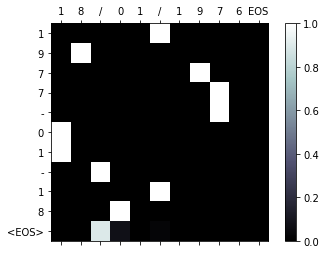

'1976-01-18'

In [ ]:
evaluateAndShowAttention(df_test.iloc[0]["Source"])
df_test.iloc[0]["Target"]

input = jun/26/1997
tensor([[2.0701e-10, 5.9322e-12, 1.4171e-16, 2.1525e-10, 1.2247e-10, 1.0000e+00,
         9.6958e-09, 3.6564e-10, 3.0876e-11, 3.2662e-10, 7.2572e-10],
        [6.2248e-08, 9.9958e-01, 3.3022e-13, 4.2148e-04, 5.2139e-08, 4.0734e-10,
         1.9729e-11, 1.2552e-06, 2.7590e-08, 7.1282e-08, 1.2968e-07],
        [1.2816e-12, 4.1650e-14, 1.4056e-10, 4.8646e-08, 8.6779e-09, 1.4459e-09,
         1.1423e-07, 1.0000e+00, 2.2691e-08, 1.3527e-08, 1.1290e-08],
        [8.3351e-11, 3.5098e-16, 1.3493e-14, 1.1602e-11, 8.8315e-11, 5.9719e-16,
         1.1812e-10, 4.9217e-07, 1.0000e+00, 1.1710e-10, 1.0959e-10],
        [5.5312e-06, 1.4278e-17, 6.2900e-07, 1.9327e-12, 6.5850e-10, 5.4048e-13,
         8.9360e-14, 3.9958e-08, 9.9999e-01, 1.4391e-09, 8.8680e-10],
        [1.0000e+00, 9.9903e-17, 4.1571e-09, 4.0571e-14, 5.2924e-11, 1.9727e-09,
         7.9761e-19, 7.3715e-12, 2.3099e-08, 3.4213e-11, 2.1658e-11],
        [9.9999e-01, 3.9147e-11, 8.1681e-10, 6.3143e-06, 1.5016e-08, 2.751

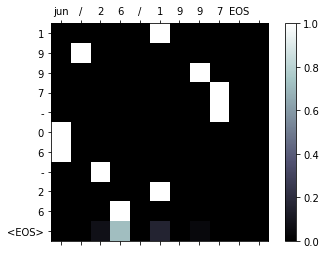

In [ ]:

evaluateAndShowAttention(df_test.iloc[10]["Source"])

## Rough

In [ ]:
tmp=df['Source'][0]
tmp='20/02/1998'
print(tmp)

words=tmp.split('/')

# d = "/"

# words = [e+d for e in tmp.split(d) if e]
# print(words)


nums=[]
print(words)
for w in words:
    if w.isdigit():
        nums.extend(c for c in w)
    else:
        nums.append(w)
        
    nums.append("/")
nums=nums[:-1]
print(nums)
        

In [ ]:
for i, row in enumerate(df.values):
    print(row[0])

In [ ]:
tmp=df['Target'][0]
# tmp='20/02/1998'
print(tmp)

words=tmp.split('-')

# d = "/"

# words = [e+d for e in tmp.split(d) if e]
# print(words)


nums=[]
print(words)
for w in words:
    if w.isdigit():
        nums.extend(c for c in w)
    else:
        nums.append(w)
        
    nums.append("-")
nums=nums[:-1]
print(nums)
        

In [ ]:
x=df.sample()
print(x)
print([x.iloc[0]["Source"],x.iloc[0]["Target"]])

In [ ]:
for i in range(len(df_valid)):
    print(df_valid.iloc[0]['Source'])
    print(df_valid.iloc[0]['Target'])